# **VAE**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import trange
from datetime import datetime
from collections import OrderedDict
from itertools import product
import os
from prettytable import PrettyTable
from sklearn.svm import SVC
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
import torch
import torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

In [0]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.is_available()

True

# **Load Fashion MNIST dataset**

In [0]:
def load_FMNIST_dataset(transform, train=True):
    return torchvision.datasets.FashionMNIST(
                root = '~/.pytorch/F_MNIST_data/',
                train = train,
                download = True,
                transform = transform
            )
# each channel is normalized to be in the range [0,1] (only one channel (grayscale))
TRANSFORM = transforms.Compose([
                                transforms.ToTensor()] 
                               ) # transforms.Normalize((0.5,), (0.5,)) 

In [0]:
BATCH_SIZE = 16
dataset_tmp = load_FMNIST_dataset(TRANSFORM)
training_set, validation_set = torch.utils.data.random_split(dataset_tmp, [50000, 10000])
test_set = load_FMNIST_dataset(TRANSFORM, train=False)

train_loader = torch.utils.data.DataLoader(training_set, batch_size = BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_set, batch_size = BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, shuffle=False)

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## **VAE- M1 scheme (from *'Semi-supervised Learning with Deep Generative Models'* )**   

* a 50-dimensional latent variable z
* Generative and inference models- two hidden layers, each with 600 hidden units
* Softplus $\log (1+ e^{x})$ activation functions
* A transductive SVM (TSVM) was learned on values of z inferred with $q_{\phi}(z \mid x)$

### **VAE class**


In [0]:
def load_model(model, model_name, folder_model):
        path_model = os.path.join(folder_model, f'{model_name}.pth')
        checkpoint = torch.load(path_model)
        model.load_state_dict(checkpoint['model_state_dict'])

        
class VAE(nn.Module):
    def __init__(self, n_flatten=1*28*28, hidden_encode_dim=600, z_dim=50,
                  hidden_decode_dim=600, output_dim=1*28*28):
        super(VAE, self).__init__()
        self.n_flatten = n_flatten
        self.fc1 = nn.Linear(n_flatten, hidden_encode_dim)
        self.fc21 = nn.Linear(hidden_encode_dim, z_dim)
        self.fc22 = nn.Linear(hidden_encode_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, hidden_decode_dim)
        self.fc4 = nn.Linear(hidden_encode_dim, output_dim)

    def encode(self, x):
        h1 = F.softplus(self.fc1(x))
        mu, log_var = self.fc21(h1), self.fc22(h1)
        return mu, log_var


    def reparameterize(self, mu, logvar):
        eps = torch.randn_like(mu)
        sd = torch.exp(0.5 * logvar)
        return mu + sd * eps

    def decode(self, z):
        h3 = F.softplus(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def create_z_given_x(self, x):
        x = x.view(-1, self.n_flatten)
        with torch.no_grad():
            self.eval()
            mu, log_var = self.encode(x)
        return self.reparameterize(mu, log_var)
    
    def forward(self, x):
        x = x.view(-1, self.n_flatten)
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var



## Hyperparameters generator

In [0]:
class HyperparamsConfig:
    def __init__(self, hyperparams_dict):
        self.hyperparams_dict = hyperparams_dict
        self.hyperparams_names = list(hyperparams_dict.keys())

    def create_configs(self):
        h_params_names = self.hyperparams_names
        for h_params_vals in product(*[h_params  for h_params in self.hyperparams_dict.values()]):
            yield {h_params_name: h_params_vals[i] for i, h_params_name in enumerate(h_params_names)}


## Model configuration per run 
* Create  a new VAE (M1 scheme) model according to specific configuration (if starting epoch=0)
* Enabing load saved model with its optimizer, scheduler and starting epoch

In [0]:
class ModelRun:
    def __init__(self, config, epochs, device, trained_model_path=''):
        self.config = config
        self.epochs = epochs
        self.model_name = ''
        self.model = VAE()
        self.device = device
        self.start_epoch = 0
        self.optimizer = self.set_optimizer()
        self.scheduler = lr_scheduler.CosineAnnealingLR(self.optimizer,epochs)
        self.dict_error = None
        if '.pth' in trained_model_path and os.path.exists(trained_model_path):
            self.load_model(trained_model_path)
    
    
    def set_optim_params(self, param_groups, params_dict):
        weight_decay = self.config.get('weight_decay', 0.0)
        if weight_decay > 0:
            params_dict['weight_decay'] = weight_decay
        for param_name, param_val in  params_dict.items():
            param_groups[param_name] = param_val


    def set_optimizer(self):
        model = self.model
        model.to(self.device)
        config = self.config
        optimizer_dict = config['optimizer_dict']
        optim_name = optimizer_dict['optim_name']
        self.set_model_name(optim_name)
        lr = self.config['lr']
        optimizer = optimizer_dict['optim_func'](model.parameters(), lr=lr)
        optimizer_params_dict = optimizer_dict['optim_params']
        self.set_optim_params(optimizer.param_groups[0], optimizer_params_dict)
        return optimizer


    def set_model_name(self, optim_name):
        config = self.config
        lr = config.get('lr')
        weight_decay = config.get('weight_decay', 0.0) 
        self.model_name = \
        f"VAE_optimizer={optim_name}_lr={lr}_weight_decay={weight_decay}"


    def get_model(self):
        return self.model
         
    def get_device(self):
        return self.device

    def get_optimizer(self):
        return self.optimizer
    
    def get_scheduler(self):
        return self.scheduler

    def get_model_name(self):
        return self.model_name
    
    def get_dict_error(self):
        return self.dict_error

    def get_epochs(self):
        return self.epochs

    def get_start_epoch(self):
        return self.start_epoch
         
    def load_model(self, path_model):
        checkpoint = torch.load(path_model)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.dict_error = checkpoint['dict_error']
        self.start_epoch = checkpoint['epoch']


## Run configuration
* fit and evaluate on validation
* enable saving the model during training

In [0]:
class RunConfig:
    def __init__(self, model_config, save_model=True, folder_checkpoint=''):
            
        self.model_config = model_config
        self.device = model_config.get_device()
        self.save_model = save_model
        self.model = model_config.get_model()
        self.optimizer = model_config.get_optimizer()
        self.scheduler = model_config.get_scheduler()
        self.epochs = model_config.get_epochs()
        self.start_epoch = model_config.get_start_epoch()
        self.model_name = model_config.get_model_name()
        self.folder_checkpoint = folder_checkpoint
        self.dict_error = model_config.get_dict_error()
        if self.dict_error is None:
            self.dict_error = OrderedDict([
                                         ('train',[]),
                                         ('validation', [])
                                         ]) 
            
    #minimizing reconstruction error and KL divergence between p(x) and q(x|z)
    # KL can be analytically solved given p(x) and q(x|z) are Gaussian
    # https://arxiv.org/abs/1312.6114
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    @staticmethod 
    def loss_function(x, x_recon, mu, logvar): 
        BCE = F.binary_cross_entropy(x_recon, x.view(-1, 784), reduction='sum')
        D_KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + D_KL

    def get_dict_error(self):
        return self.dict_error

    def get_model_name(self):
        return self.model_name

    def get_epochs(self):
        return self.epochs
    
    def evaluate(self, eval_loader, lst_loss):
        device = self.device
        with torch.no_grad():
            self.model.eval()
            running_loss = 0.0
            for eval_img, eval_labels in eval_loader:
                eval_img, eval_labels = eval_img.to(device), eval_labels.to(device)
                img_recon, mu, log_var = self.model(eval_img) 
                loss = self.loss_function(eval_img, img_recon, mu, log_var)
                running_loss += loss.item()
                
            total_loss = running_loss / len(eval_loader.dataset)
            lst_loss.append(total_loss)
        self.model.train()


    def save_checkpoint(self, epoch):
        model_saved_name = self.model_name + f'_epoch={epoch+1}'
        full_path = os.path.join(self.folder_checkpoint,
                                 f'{model_saved_name}.pth')
        torch.save({'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'scheduler_state_dict': self.scheduler.state_dict(),
                    'dict_error': self.dict_error,
                    'epoch':{epoch+1}}, full_path)
        

    def fit(self, train_loader, val_loader):
        names = list(self.dict_error.keys())
        lst_loss_train = self.dict_error['train']
        lst_loss_val = self.dict_error['validation']
        device = self.device
        model = self.model.to(device)
        start_epoch, epochs = self.start_epoch, self.epochs
        with trange(start_epoch, epochs, desc="Epochs", disable=False) as te:
            model.train()
            for epoch in te:
                running_loss = 0.0
                for tr_img, tr_labels in train_loader:
                    tr_img, tr_labels = tr_img.to(device), tr_labels.to(device)
                    self.optimizer.zero_grad()
                    img_recon, mu, log_var = model(tr_img) 
                    loss = self.loss_function(tr_img, img_recon, mu, log_var)
                    loss.backward()
                    self.optimizer.step()
                    running_loss += loss.item()
                
                total_loss = running_loss / len(train_loader.dataset)
                te.set_postfix(loss=total_loss) 
                self.evaluate(train_loader, lst_loss_train)
                self.evaluate(val_loader, lst_loss_val)

                self.scheduler.step()   

                if self.save_model and ((epoch >= 2 and lst_loss_val[-1] < lst_loss_val[-2]) or (epoch == epochs-1)):
                    self.save_checkpoint(epoch)
    
    def print_loss(self): 
        names = list(self.dict_error.keys())
        lst_loss_train = self.dict_error[names[0]]
        lst_loss_val = self.dict_error[names[1]]
        t = PrettyTable(['Epoch', f'{names[0]} loss', f'{names[1]} loss'])
        for i in range(len(lst_loss_train)):
            t.add_row([i+1, lst_loss_train[i], lst_loss_val[i]])
        print(t)





## **Plots**
* write to tensorboard when tuning on validation set
* make plots after choosing best hyperparams and check also on test set

In [0]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir=runs

In [0]:
# %kill 1135 (or !kill 1135)

In [0]:
# writer for tuning hyperparameters (on validation set)
def plot_hyperparams(dict_loss, model_name): # start_epoch
    writer = SummaryWriter()
    names = list(dict_loss.keys())
    loss_train = dict_loss[names[0]]
    loss_val = dict_loss[names[1]]
    epochs = len(loss_train)
    for i in range(epochs): # start_epoch
        tag_scalar_dict = {names[0]: loss_train[i], names[1]: loss_val[i]}
        writer.add_scalars(f'Loss/{model_name}', tag_scalar_dict, i+1)
    writer.close()

# save plots of best models (on test set)
def plot_loss(dict_loss, model_name, folder_plot, 
                  y_label='Loss', x_label='Epochs'):  # start_epoch
    df_loss = pd.DataFrame(dict_loss)
    df_loss.set_index(pd.Index(range(1, df_loss.shape[0] + 1)), inplace=True)
    sns.lineplot(data=df_loss)
    title = model_name.replace('_weight_decay=','\nweight_decay=')
    plt.title(title)
    # plt.ylim(0.85, 0.96)
    plt.ylabel(y_label)
    # plt.xlim(1,10)
    plt.xlabel(x_label)
    # plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(folder_plot,f"{model_name}_{datetime.now().strftime('%y%m%d_%H%M%S')}.png"))
    plt.show() #new
    # plt.close() #new

def plot_reconstructed_image(x_recon, title, plot_folder, img_shape=(28,28)):
    x_recon = x_recon.reshape(img_shape)
    plt.imshow(x_recon, cmap='gray')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(folder_plot,f"{title}_{datetime.now().strftime('%y%m%d_%H%M%S')}.png"))
    plt.close()



## **Train VAE**

In [0]:
from google.colab import drive
drive.mount('/content/drive')
ROOT_PATH = '/content/drive/My Drive/DL-Raja/HW3/ex3_304827702_201271509/VAE'
os.chdir(ROOT_PATH)
os.getcwd()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


'/content/drive/My Drive/DL-Raja/HW3/ex3_304827702_201271509/VAE'

In [0]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 30
FOLDER_CHECKPOINT = os.path.join(os.getcwd(), 'checkpoint')
FOLDER_PLOT = os.path.join(os.getcwd(), "plots")
os.makedirs(FOLDER_CHECKPOINT,exist_ok=True)
os.makedirs(FOLDER_PLOT,exist_ok=True)


def train_vae(**args):
    start_epoch = args.get('start_epoch', 0)
    save_model = args.get('save_model', True)
    dir_model = args.get('dir_model', '')
    scalars_plot = args.get('scalars_plot', False) 
    tr_val_plot = args.get('tr_val_plot', False) 
    folder_model = os.path.join(os.getcwd(), dir_model)
    dict_h_params = args.get('dict_h_params')
    config_h_params = HyperparamsConfig(dict_h_params)
    train_loader = args.get('train_loader')
    val_loader = args.get('val_loader')

    for config in config_h_params.create_configs():
        print(f'config:\n{config}')
        model_run = ModelRun(config, EPOCHS, DEVICE, folder_model)
        config_run = RunConfig(model_run, save_model, FOLDER_CHECKPOINT)
        config_run.fit(train_loader, val_loader)
        config_run.print_loss()
        dict_error = config_run.get_dict_error()
        model_name = config_run.get_model_name()
        if scalars_plot:
            plot_hyperparams(dict_error, model_name)
        if tr_val_plot:
            plot_loss(dict_error, model_name, FOLDER_PLOT)
        


## Find best hyperparameters using validation set

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

config:
{'optimizer_dict': {'optim_name': 'Adam', 'optim_func': <class 'torch.optim.adam.Adam'>, 'optim_params': {'betas': (0.9, 0.999)}}, 'lr': 0.0008, 'weight_decay': 0.0001}


Epochs: 100%|██████████| 30/30 [15:16<00:00, 30.55s/it, loss=239]


+-------+--------------------+--------------------+
| Epoch |     train loss     |  validation loss   |
+-------+--------------------+--------------------+
|   1   | 255.88217252929687 | 255.45364580078126 |
|   2   | 250.35713276367187 | 250.06529770507814 |
|   3   | 248.65369596679687 | 248.35134931640624 |
|   4   | 246.74389646972656 | 246.48538244628907 |
|   5   | 245.9555928173828  | 245.77786938476564 |
|   6   | 244.99602979003907 | 244.75212587890624 |
|   7   | 244.18196563964844 | 244.06336931152345 |
|   8   | 243.8068630078125  | 243.64247509765624 |
|   9   | 243.35049827148438 |  243.258123828125  |
|   10  | 242.98967880859374 | 242.97561572265624 |
|   11  | 242.1882390527344  | 242.09311291503906 |
|   12  | 241.89041249511718 | 241.90742687988282 |
|   13  | 241.47069135742188 | 241.46170561523437 |
|   14  | 241.48054843261718 | 241.56412189941406 |
|   15  | 240.96144729492187 | 241.02369477539062 |
|   16  | 240.5988121826172  | 240.58462084960937 |
|   17  | 24

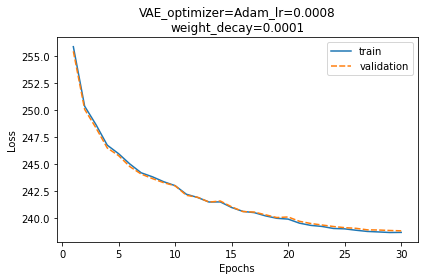

In [0]:
param_best = OrderedDict([
                          ('optimizer_dict', [{'optim_name': 'Adam', 'optim_func': optim.Adam, 'optim_params': { 'betas':(0.9, 0.999)}}]), # 'betas':(0.9, 0.999)
                          ('lr', [8e-4]), 
                          ('weight_decay', [1e-4]) 
                          ])
train_vae(dict_h_params=param_best, train_loader=train_loader, val_loader=val_loader, tr_val_plot=True)

## **Transductive SVM**

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
#convert dataset for training and test set
def create_latent_dataset(vae, data_loader, device, seed=1):
    Xs, ys = [], []
    torch.manual_seed(seed)
    for data_img, data_labels in data_loader:
        data_img = data_img.to(device)
        data_latent = vae.create_z_given_x(data_img)
        Xs.append(data_latent.detach().cpu().numpy())
        ys.append(data_labels.detach().cpu().numpy())
    Xs, ys = np.concatenate(Xs), np.concatenate(ys)
    print(f'Xs is of shape {Xs.shape}\nys is of shape {ys.shape}')
    return Xs, ys


def save_dataset(X, y , folder_path, file_name):
        np.savez_compressed(os.path.join(folder_path, file_name), X=X, y=y)


def save_datasets(X_y_pairs, folder_path, file_name):
    for i, (X,y) in enumerate(X_y_pairs):
        file_name = f'{file_name}_{i+1}'
        save_dataset(X, y, folder_path, file_name)


def load_dataset(folder_path, file_name):
    loaded = np.load(os.path.join(folder_path, file_name + '.npz'), allow_pickle=True)
    X, y = loaded["X"], loaded["y"]
    return X, y


def load_datasets(folder_path, file_name, cv=5):
    X_y_pairs = []
    for i in range(1, cv+1):
        X, y = load_dataset(foler_path, f'{file_name}_{i}')
        X_y_pairs.append((X, y))
    return X_y_pairs


class DatasetCV:
    def __init__(self, k_total, seed, cv=5):
        self.k_total = k_total
        self.cv = cv
        self.seed = seed

    
    def create_cv_set(self, X, y):
        skf = StratifiedKFold(n_splits=self.cv, random_state=None, shuffle=False)
        X_y_tr = []
        X_y_te = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # print(f'y_train vals:\n{Counter(y_train)}\ny_test vals:\n{Counter(y_test)}')
            X_y_tr.append((X_train, y_train))
            X_y_te.append((X_test, y_test))
        return X_y_tr, X_y_te


    def random_suffling_splits(self, X, y): #X, y - numpy array (train)
        np.random.seed(self.seed)
        X_tr = []
        y_tr = []
        idx_arr = np.arange(y.size)
        labels = np.unique(y)
        k = self.k_total // len(labels)
        for label in labels:
            label_idxes = idx_arr[y == label]
            tr_idxes = np.random.choice(label_idxes, k, replace=False)
            X_tr.append(X[tr_idxes, :])
            y_tr.append(y[tr_idxes])
        X_tr, y_tr = np.concatenate(X_tr), np.concatenate(y_tr)
        X_y_tr, X_y_te = self.create_cv_set(X_tr, y_tr)
        return X_y_tr, X_y_te


def calc_error_rate(model, X_te, y_te):
        preds = model.predict(X_te)
        error_rate = np.mean(preds != y_te) * 100
        return error_rate


def load_TSVM(model_name, folder_model):
    full_path = os.path.join(folder_model, f'{model_name}.pkl')
    # print(f'full path = {full_path}')
    model = joblib.load(full_path)
    return model


def load_TSVMs(k, folder_model, cv=5):
    models = []
    for i in range(1, cv+1):
        model_name = f'TSVC_{i}_k={k}'
        # print(f'model_name = {model_name}')
        models.append(load_TSVM(model_name, folder_model))
    return models


def make_preds(models, X_te, y_te):
    error_rate_vec = np.zeros(len(models))
    for i, model in enumerate(models):
        error_rate_vec[i] += calc_error_rate(model, X_te, y_te)
    return error_rate_vec.mean(), error_rate_vec.std()


class TSVC:
    def __init__(self, X_y_tr_pairs, X_y_te_pairs, dict_params, k):
        self.X_y_tr_pairs = X_y_tr_pairs
        self.X_y_te_pairs = X_y_te_pairs
        self.hyper_params = HyperparamsConfig(dict_params)
        self.k = k

    @staticmethod
    def save_TSVM(model, model_name, folder_model):
        joblib.dump(model, os.path.join(folder_model, f'{model_name}.pkl'))

    @staticmethod
    def train_TSVM(X_tr, y_tr, X_te, y_te, params):
        tsvc = SVC(**params)
        tsvc.fit(X_tr, y_tr)
        errror_rate = calc_error_rate(tsvc, X_te, y_te)
        return errror_rate, tsvc

    
    def save_best_TSVM(self, folder_model):
        best_tsvcs = []
        best_loss = np.inf
        best_hyperparams = None
        print(f'k = {k}')
        cv = len(self.X_y_tr_pairs)
        for hyperparams in self.hyper_params.create_configs():
            tmp_tscvs = []
            loss = 0
            for i in range(cv):
                X_tr, y_tr = self.X_y_tr_pairs[i]
                X_te, y_te = self.X_y_te_pairs[i]
                # print(f'X_tr.shape = {X_tr.shape}\tX_te.shape = {X_te.shape}')
                # print(f'y_tr.shape = {y_tr.shape}\ny_te.shape = {y_te.shape}')
                error_rate, tsvc = self.train_TSVM(X_tr, y_tr, X_te, y_te, hyperparams)
                tmp_tscvs.append(tsvc)
                loss += error_rate
            loss /= cv
            print(f'hyperparams = {hyperparams}\tmean error_rate = {loss}')
            if best_loss >= loss:
                best_loss = loss
                best_tsvcs = tmp_tscvs
                best_hyperparams = hyperparams
        print(f'best parameters:\n{best_hyperparams}')
        for i, best_tsvc in enumerate(best_tsvcs, 1):
            model_name = f'TSVC_{i}_k={k}'
            self.save_TSVM(best_tsvc, model_name, folder_model)


## Train TSVM on latent examples

### Create dataset for CV

In [0]:
model_name = 'VAE_optimizer=Adam_lr=0.0008_weight_decay=0.0001_epoch=30'
params_tsvm = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                  'C': [0.01, 0.1, 1, 10, 100]}
Ks = [100, 600, 1000, 3000]

In [0]:
vae = VAE()
load_model(vae, model_name, FOLDER_CHECKPOINT)
vae.to(DEVICE)
X_latent_train, y_train = create_latent_dataset(vae, train_loader, DEVICE)

Xs is of shape (50000, 50)
ys is of shape (50000,)


In [0]:
for k in Ks:
    dataset_cv = DatasetCV(k, SEED, cv=10)
    X_y_tr, X_y_te = dataset_cv.random_suffling_splits(X_latent_train, y_train)
    vae_m1 = TSVC(X_y_tr, X_y_te, params_tsvm, k)
    vae_m1.save_best_TSVM(FOLDER_CHECKPOINT)

k = 100
hyperparams = {'kernel': 'rbf', 'gamma': 0.001, 'C': 0.01}	mean error_rate = 54.0
hyperparams = {'kernel': 'rbf', 'gamma': 0.001, 'C': 0.1}	mean error_rate = 54.0
hyperparams = {'kernel': 'rbf', 'gamma': 0.001, 'C': 1}	mean error_rate = 54.0
hyperparams = {'kernel': 'rbf', 'gamma': 0.001, 'C': 10}	mean error_rate = 45.0
hyperparams = {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}	mean error_rate = 51.0
hyperparams = {'kernel': 'rbf', 'gamma': 0.0001, 'C': 0.01}	mean error_rate = 53.0
hyperparams = {'kernel': 'rbf', 'gamma': 0.0001, 'C': 0.1}	mean error_rate = 53.0
hyperparams = {'kernel': 'rbf', 'gamma': 0.0001, 'C': 1}	mean error_rate = 53.0
hyperparams = {'kernel': 'rbf', 'gamma': 0.0001, 'C': 10}	mean error_rate = 53.0
hyperparams = {'kernel': 'rbf', 'gamma': 0.0001, 'C': 100}	mean error_rate = 45.0
best parameters:
{'kernel': 'rbf', 'gamma': 0.0001, 'C': 100}
k = 600
hyperparams = {'kernel': 'rbf', 'gamma': 0.001, 'C': 0.01}	mean error_rate = 37.33333333333333
hyperparams = {'

### Load (latent) test set and best TSVM models, and calculate total number of errors
* test set and load VAE
* transform test test (Z-dimensional)
* load SVM models
* make predictions

In [0]:
BATCH_SIZE = 16
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
FOLDER_CHECKPOINT = os.path.join(os.getcwd(), 'checkpoint')
os.makedirs(FOLDER_CHECKPOINT,exist_ok=True)

In [0]:
dataset_tmp = load_FMNIST_dataset(TRANSFORM)
test_set = load_FMNIST_dataset(TRANSFORM, train=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, shuffle=False)

In [0]:
model_name = 'VAE_optimizer=Adam_lr=0.0008_weight_decay=0.0001_epoch=30'
vae = VAE()
load_model(vae, model_name, FOLDER_CHECKPOINT)
vae.to(DEVICE)
X_latent_test, y_test = create_latent_dataset(vae, test_loader, DEVICE)

Xs is of shape (10000, 50)
ys is of shape (10000,)


In [0]:
t = PrettyTable(['N', 'M1+TSVM'])
for k in Ks:
    models = load_TSVMs(k, FOLDER_CHECKPOINT)
    #load X_te and y_te
    mean_errors, sd_errors = make_preds(models, X_latent_test, y_test)
    t.add_row([k, f'{mean_errors} (+/- {sd_errors})'])
print(t)

+------+----------------------------------+
|  N   |             M1+TSVM              |
+------+----------------------------------+
| 100  | 53.524 (+/- 0.6193738773955546)  |
| 600  | 33.748 (+/- 0.3292051032411258)  |
| 1000 |  29.794 (+/- 0.347136860618404)  |
| 3000 | 24.524 (+/- 0.20499756096110028) |
+------+----------------------------------+
